In [1]:
%conda install -c conda-forge matplotlib 
%conda install -c anaconda scipy
!pip install tqdm h5py zarr pillow numpy imgaug==0.4.0 mahotas #imgaug has dependency on previous packages
!pip install scikit-image
!pip install tensorboard
!pip install torchsummary

Solving environment: done

## Package Plan ##

  environment location: /home/xiaoyan/anaconda3/envs/07_instance_segmentation

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-3.4.3           |   py39hf3d152e_1           7 KB  conda-forge
    ------------------------------------------------------------
                                           Total:           7 KB

The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2020.10.14-0 --> conda-forge::ca-certificates-2021.5.30-ha878542_0
  matplotlib                           3.4.3-py39hf3d152e_0 --> 3.4.3-py39hf3d152e_1



matplotlib-3.4.3     | 7 KB      | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
So

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import torch
from __future__ import division, print_function
from torch.utils.data import Dataset
import glob
import os
import zarr
import random
import datetime
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# import h5py
# from imgaug import augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapsOnImage
# from imgaug.augmentables.heatmaps import HeatmapsOnImage
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from skimage import io
from utils.colormap import *
from unet_fov import *

plt.rcParams['image.cmap'] = 'gist_earth'
torch.backends.cudnn.benchmark = True

In [3]:
# decompress data
from shutil import unpack_archive
unpack_archive(os.path.join('datasets','example_toy_data.zip'), './')

In [4]:
def running_mean(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

def plot_history(history):
    # plot training and validation loss and binary accuracy
    
    loss = running_mean(history['loss'], 9)
    val_loss = running_mean(history['val_loss'], 9)
    #epochs = len(history.history['loss'])
    epochs = len(loss)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(0, epochs), loss , label='loss')
    ax1.plot(range(0, epochs), val_loss, label='val_loss')
    ax1.set_title('train and validation loss')
    ax1.legend(loc='upper right')
    
    acc = running_mean(history['binary_accuracy'], 9)
    val_acc = running_mean(history['val_binary_accuracy'], 9)

    ax2.plot(range(0, epochs), acc, label='binary_accuracy')
    ax2.plot(range(0, epochs), val_acc, label='val_binary_accuracy')
    ax2.set_title('train and validation binary accuracy')
    ax2.legend(loc='lower right')

    plt.show()

In [5]:
def show_predictions(raw, gt, pred):
    
    thresh = 0.9
    max_values = np.max(pred[:,0], axis=(1, 2))
    if np.any(max_values < thresh):
        print("Heads up: If prediction is below {} then the prediction map is shown.".format(thresh))
        print("Max predictions: {}".format(max_values))
    
    num_samples = pred.shape[0]
    fig, ax = plt.subplots(num_samples, 3, sharex=True, sharey=True, figsize=(12, num_samples * 4))
    for i in range(num_samples):
        ax[i, 0].imshow(raw[i,0], aspect="auto")
        ax[i, 1].imshow(gt[i,0], aspect="auto")
        # check for prediction threshold
        if np.sum(max_values[i]) < thresh:
            ax[i, 2].imshow(pred[i,0], aspect="auto")
        else:
            ax[i, 2].imshow(pred[i,0] >= thresh, aspect="auto")

    ax[0, 0].set_title("Input")
    ax[0, 1].set_title("Ground truth")
    ax[0, 2].set_title("Prediction")
    fig.tight_layout()

## (1) Load and visualize our toy data examples:


we have 12 train samples, 3 validation samples and 3 test samples.

In [6]:
# load tif images and reformat it
def load_dataset(in_folder):
    x = []
    y = []
    raw_files = glob.glob(in_folder + '/raw_*.tif')
    for raw_file in raw_files:
        x.append(io.imread(raw_file)) 
        y.append(io.imread(raw_file.replace('raw', 'gt'))) 
    x = np.array(x)[:, np.newaxis] #shape [N, 1, H, W]
    y = np.array(y)[:, np.newaxis] #shape [N, 1, H, W]
    return x, y

In [7]:
# load data into train/val/test sets
x_train, y_train = load_dataset('example_toy_data/train')
x_val, y_val = load_dataset('example_toy_data/val')
x_test, y_test = load_dataset('example_toy_data/test')

batch_size = 4
# make dataloaders
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(list(zip(x_val, y_val)), batch_size=1, pin_memory=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=1)

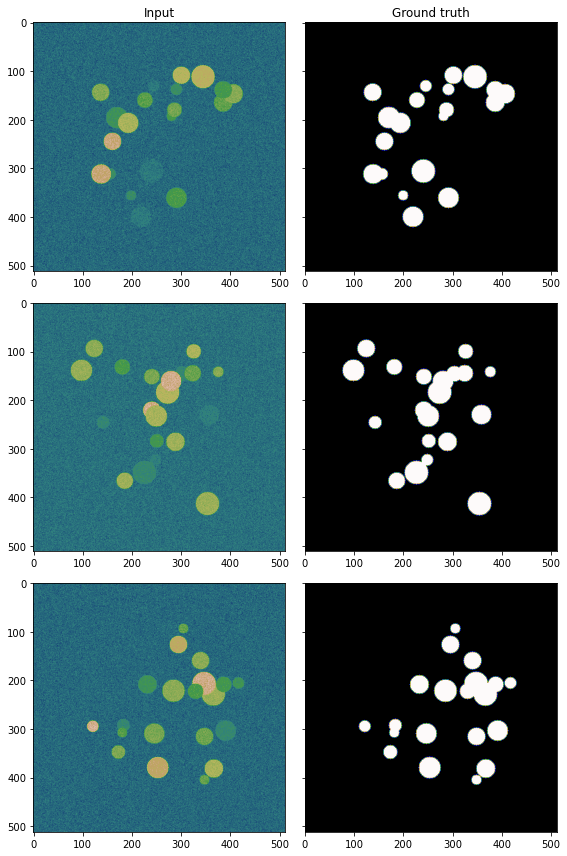

In [8]:
# show training examples
num_samples = 3
fig, ax = plt.subplots(num_samples, 2, sharey=True, figsize=(8, num_samples * 4))
for i in range(num_samples):
    ax[i, 0].imshow(x_train[i,0], aspect="auto")
    ax[i, 1].imshow(y_train[i,0], aspect="auto")
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Ground truth")
fig.tight_layout()

## (2) Create and train our model

In [9]:
# set seed
torch.manual_seed(42)

# define model
out_channels = 1
d_factors = [[2,2],[2,2],[2,2],[2,2]]
activation = torch.nn.Sigmoid()

net = torch.nn.Sequential(
    UNet(in_channels=1,
    num_fmaps=6,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='same',
    num_fmaps_out=6,
    constant_upsample=False
    ),
    torch.nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

receptive_field, _ = net[0].get_fov()

# print network layers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
summary(net, (1,512,512))
print("Receptive field: ", receptive_field)

/home/xiaoyan/anaconda3/envs/07_instance_segmentation/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 512, 512]              60
              ReLU-2          [-1, 6, 512, 512]               0
            Conv2d-3          [-1, 6, 512, 512]             330
              ReLU-4          [-1, 6, 512, 512]               0
          ConvPass-5          [-1, 6, 512, 512]               0
         MaxPool2d-6          [-1, 6, 256, 256]               0
        Downsample-7          [-1, 6, 256, 256]               0
            Conv2d-8         [-1, 12, 256, 256]             660
              ReLU-9         [-1, 12, 256, 256]               0
           Conv2d-10         [-1, 12, 256, 256]           1,308
             ReLU-11         [-1, 12, 256, 256]               0
         ConvPass-12         [-1, 12, 256, 256]               0
        MaxPool2d-13         [-1, 12, 128, 128]               0
       Downsample-14         [-1, 12, 1

### Receptive Field of View

The number of convolutions and the depth of the U-Net are the major factors in determining the 
receptive field of the network. The term is borrowed from biology where it describes the "portion of sensory space that can elicit neuronal responses when stimulated" (wikipedia). Each output pixel can look at/depends on an input patch with that diameter centered at its position.
Based on this patch, the network has to be able to make a decision about the prediction for the respective pixel.
Yet larger sizes increase the computation time significantly.

The following code snippet visualizes the field of view of the center pixel for networks with varying depth:

Field of view at depth 1:   5 (color: yellow)
Field of view at depth 2:  18 (color: red)
Field of view at depth 3:  44 (color: green)
Field of view at depth 4:  96 (color: blue)


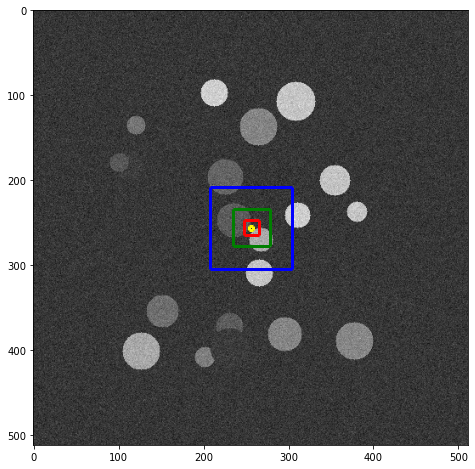

In [10]:
rnd = random.randrange(len(x_train))
image = x_train[rnd]
label = y_train[rnd]


net_t = image
fovs = []
d_factors = [[2,2],[2,2],[2,2],[2,2]]

for level in range(len(d_factors)):
    fov_tmp, _ = net[0].rec_fov(level , (1, 1), 1)
    fovs.append(fov_tmp[0])

image = np.squeeze(image)
fig=plt.figure(figsize=(8, 8))
colors = ["yellow", "red", "green", "blue", "magenta"]
plt.imshow(image, cmap='gray')
for idx, fov_t in enumerate(fovs):
    print("Field of view at depth {}: {:3d} (color: {})".format(idx+1, fov_t, colors[idx]))
    xmin = image.shape[1]/2 - fov_t/2
    xmax = image.shape[1]/2 + fov_t/2
    ymin = image.shape[1]/2 - fov_t/2
    ymax = image.shape[1]/2 + fov_t/2
    plt.hlines(ymin, xmin, xmax, color=colors[idx], lw=3)
    plt.hlines(ymax, xmin, xmax, color=colors[idx], lw=3)
    plt.vlines(xmin, ymin, ymax, color=colors[idx], lw=3)
    plt.vlines(xmax, ymin, ymax, color=colors[idx], lw=3)
plt.show()

In [11]:
dtype = torch.FloatTensor
def training_step(model, loss_fn, optimizer, feature, label):
    # speedup version of setting gradients to zero
    for param in model.parameters():
        param.grad = None
    # forward
    logits = model(feature) # B x C x H x W
    loss_value = loss_fn(input=logits, target=label) # label.squeeze(0) for three_class
    # backward if training mode
    if net.training:
        loss_value.backward()
        optimizer.step()
    if activation is not None:
        output = activation(logits)
    else:
        output = logits
    outputs = {
        'pred': output,
        'logits': logits,
    }
    return loss_value, outputs

def calc_accuracy(y_pred, y_true):
    y_pred=torch.ge(y_pred, 0.5)
   # y_pred = torch.round(y_pred)
    return y_pred.eq(y_true).float().mean()
                
def train(net, epochs, learning_rate,start_epoch=0, optimizer=None, history=None, early_stopping=None,img_gen=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    loss_fn = loss_fn.to(device)
    # set optimizer
    if optimizer is None:
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    if history is None:
        history = {'loss':[],
                  'val_loss':[],
                  'binary_accuracy':[],
                  'val_binary_accuracy':[]}
    if img_gen:
        pbar = tqdm(total=epochs)
    else:
        pbar = tqdm(total=epochs*len(train_loader))
    for epoch in range(0, epochs):
    #for epoch in tqdm(range(0, epochs)):
        
        if img_gen:
            net.train()
            train_acc_loss = []
            train_acc_accuracy = []
            feature,label=next(img_gen)
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
            pbar.update(1)
            train_acc_loss.append(loss_value.cpu().detach().numpy())
            accuracy = calc_accuracy(outputs['pred'], label)
            train_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        else:
            # reset data loader to get random augmentations
            np.random.seed()
            tmp_loader = iter(train_loader)
            train_acc_loss = []
            train_acc_accuracy = []
            net.train()
            for feature, label in tmp_loader:
                label = label.type(dtype)
                label = label.to(device)
                feature = feature.to(device)
                loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
                pbar.update(1)
                train_acc_loss.append(loss_value.cpu().detach().numpy())
                accuracy = calc_accuracy(outputs['pred'], label)
                train_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        history['loss'].append(np.mean(train_acc_loss))
        history['binary_accuracy'].append(np.mean(train_acc_accuracy))
        # validation
        net.eval()
        tmp_val_loader = iter(val_loader)
        val_acc_loss = []
        val_acc_accuracy = []
        for feature, label in tmp_val_loader:                    
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, outputs = training_step(net, loss_fn, optimizer, feature, label)
            val_acc_loss.append(loss_value.cpu().detach().numpy())
            accuracy = calc_accuracy(outputs['pred'], label)
            val_acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        history['val_loss'].append(np.mean(val_acc_loss))
        history['val_binary_accuracy'].append(np.mean(val_acc_accuracy))
        if early_stopping:
            #early_stopping(np.mean(acc_loss))
            early_stopping(np.mean(val_acc_loss))
            if early_stopping.early_stop:
                print('Early stopping after epoch', epoch)
                break
        print(f'Epoch {epoch+start_epoch+1}, train-loss: {np.mean(train_acc_loss):.4f} - train_accuracy:{np.mean(train_acc_accuracy):.4f}'+
      f' - val_loss:{np.mean(val_acc_loss):.4f} -val_accuracy:{np.mean(val_acc_accuracy):.4f}')
    return net, history, optimizer

In [12]:
num_epochs1 = 250
net, history, optimizer = train(net, num_epochs1, learning_rate=5e-4,start_epoch=0)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1, train-loss: 0.6425 - train_accuracy:0.9295 - val_loss:0.6399 -val_accuracy:0.9294
Epoch 2, train-loss: 0.6386 - train_accuracy:0.9295 - val_loss:0.6360 -val_accuracy:0.9294
Epoch 3, train-loss: 0.6345 - train_accuracy:0.9295 - val_loss:0.6321 -val_accuracy:0.9294
Epoch 4, train-loss: 0.6309 - train_accuracy:0.9295 - val_loss:0.6291 -val_accuracy:0.9294
Epoch 5, train-loss: 0.6285 - train_accuracy:0.9295 - val_loss:0.6271 -val_accuracy:0.9294
Epoch 6, train-loss: 0.6264 - train_accuracy:0.9295 - val_loss:0.6251 -val_accuracy:0.9294
Epoch 7, train-loss: 0.6243 - train_accuracy:0.9295 - val_loss:0.6230 -val_accuracy:0.9294
Epoch 8, train-loss: 0.6222 - train_accuracy:0.9295 - val_loss:0.6207 -val_accuracy:0.9294
Epoch 9, train-loss: 0.6198 - train_accuracy:0.9295 - val_loss:0.6182 -val_accuracy:0.9294
Epoch 10, train-loss: 0.6172 - train_accuracy:0.9295 - val_loss:0.6152 -val_accuracy:0.9294
Epoch 11, train-loss: 0.6140 - train_accuracy:0.9295 - val_loss:0.6116 -val_accuracy:0.92

Epoch 93, train-loss: 0.0910 - train_accuracy:0.9716 - val_loss:0.0816 -val_accuracy:0.9742
Epoch 94, train-loss: 0.0839 - train_accuracy:0.9715 - val_loss:0.1071 -val_accuracy:0.9672
Epoch 95, train-loss: 0.0809 - train_accuracy:0.9740 - val_loss:0.0783 -val_accuracy:0.9741
Epoch 96, train-loss: 0.0818 - train_accuracy:0.9719 - val_loss:0.1402 -val_accuracy:0.9690
Epoch 97, train-loss: 0.0770 - train_accuracy:0.9769 - val_loss:0.0740 -val_accuracy:0.9761
Epoch 98, train-loss: 0.0763 - train_accuracy:0.9752 - val_loss:0.0922 -val_accuracy:0.9689
Epoch 99, train-loss: 0.0746 - train_accuracy:0.9751 - val_loss:0.0766 -val_accuracy:0.9764
Epoch 100, train-loss: 0.0699 - train_accuracy:0.9784 - val_loss:0.0904 -val_accuracy:0.9747
Epoch 101, train-loss: 0.0703 - train_accuracy:0.9776 - val_loss:0.0797 -val_accuracy:0.9733
Epoch 102, train-loss: 0.0679 - train_accuracy:0.9776 - val_loss:0.0767 -val_accuracy:0.9745
Epoch 103, train-loss: 0.0646 - train_accuracy:0.9789 - val_loss:0.0768 -val_

Epoch 185, train-loss: 0.0418 - train_accuracy:0.9865 - val_loss:0.0446 -val_accuracy:0.9866
Epoch 186, train-loss: 0.0413 - train_accuracy:0.9859 - val_loss:0.0397 -val_accuracy:0.9872
Epoch 187, train-loss: 0.0397 - train_accuracy:0.9867 - val_loss:0.0441 -val_accuracy:0.9864
Epoch 188, train-loss: 0.0379 - train_accuracy:0.9868 - val_loss:0.1606 -val_accuracy:0.9194
Epoch 189, train-loss: 0.0413 - train_accuracy:0.9864 - val_loss:0.0381 -val_accuracy:0.9861
Epoch 190, train-loss: 0.0421 - train_accuracy:0.9858 - val_loss:0.0437 -val_accuracy:0.9846
Epoch 191, train-loss: 0.0435 - train_accuracy:0.9859 - val_loss:0.0425 -val_accuracy:0.9865
Epoch 192, train-loss: 0.0409 - train_accuracy:0.9866 - val_loss:0.0527 -val_accuracy:0.9875
Epoch 193, train-loss: 0.0414 - train_accuracy:0.9872 - val_loss:0.0458 -val_accuracy:0.9879
Epoch 194, train-loss: 0.0402 - train_accuracy:0.9872 - val_loss:0.0401 -val_accuracy:0.9879
Epoch 195, train-loss: 0.0370 - train_accuracy:0.9876 - val_loss:0.038

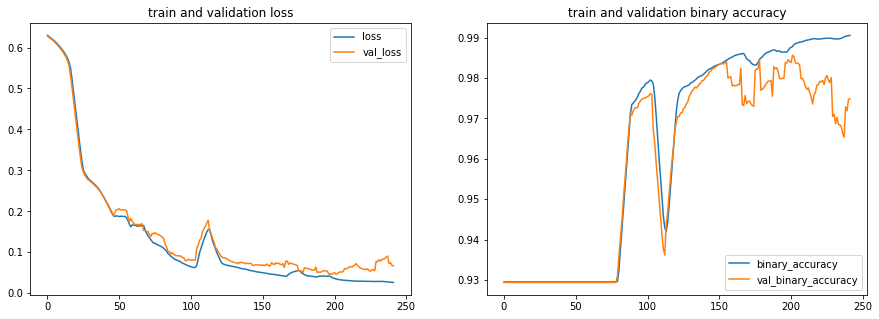

In [13]:
# plot loss and accuracy
plot_history(history)

## (3) Test and evaluate our model

Accuracy: 0.989


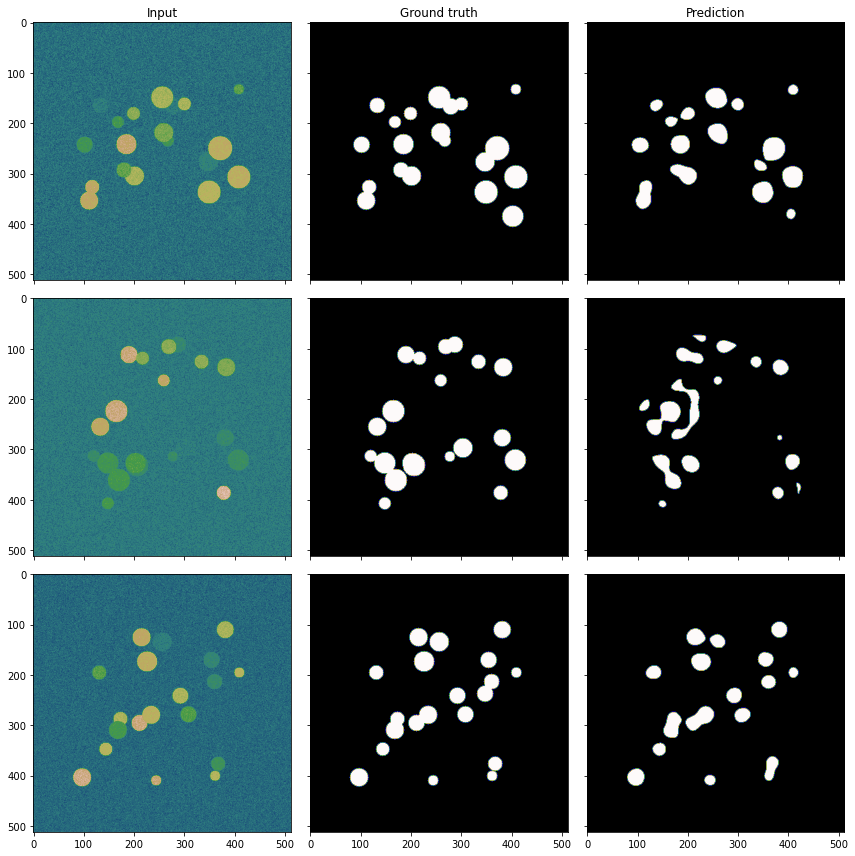

In [14]:
# predict the test set
def predict(net, test_loader):
    net.eval()
    predictions = []
    acc_accuracy = []
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        pred = net(image)
        pred = activation(pred)
        accuracy = calc_accuracy(pred, label)
        acc_accuracy.append(float(accuracy.cpu().detach().numpy()))
        image = np.squeeze(image.cpu())
        pred = np.squeeze(pred.cpu().detach().numpy(),0)
        predictions.append(pred)
    acc_accuracy = []
    return predictions, float(accuracy.cpu().numpy())
    
# plot predicted results
predictions, accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(accuracy))
show_predictions(x_test, y_test, predictions)

### A1: Continue training for more epochs

In [15]:
# continue training, takes ~3min
# heads up: the "net" variable still carries all the information from the previous training
num_epochs2=160
net, continued_history, optimizer = train(net, epochs=num_epochs2, learning_rate=1e-4, start_epoch=num_epochs1,history=history, optimizer=optimizer)

print('Finished Training')

  0%|          | 0/480 [00:00<?, ?it/s]

Epoch 251, train-loss: 0.0254 - train_accuracy:0.9908 - val_loss:0.0469 -val_accuracy:0.9828
Epoch 252, train-loss: 0.0274 - train_accuracy:0.9898 - val_loss:0.0597 -val_accuracy:0.9774
Epoch 253, train-loss: 0.0278 - train_accuracy:0.9903 - val_loss:0.0793 -val_accuracy:0.9702
Epoch 254, train-loss: 0.0265 - train_accuracy:0.9902 - val_loss:0.0373 -val_accuracy:0.9866
Epoch 255, train-loss: 0.0276 - train_accuracy:0.9901 - val_loss:0.1133 -val_accuracy:0.9572
Epoch 256, train-loss: 0.0265 - train_accuracy:0.9903 - val_loss:0.0540 -val_accuracy:0.9800
Epoch 257, train-loss: 0.0262 - train_accuracy:0.9904 - val_loss:0.0494 -val_accuracy:0.9821
Epoch 258, train-loss: 0.0261 - train_accuracy:0.9904 - val_loss:0.0594 -val_accuracy:0.9777
Epoch 259, train-loss: 0.0249 - train_accuracy:0.9909 - val_loss:0.0534 -val_accuracy:0.9804
Epoch 260, train-loss: 0.0250 - train_accuracy:0.9910 - val_loss:0.0903 -val_accuracy:0.9656
Epoch 261, train-loss: 0.0248 - train_accuracy:0.9908 - val_loss:0.059

Epoch 343, train-loss: 0.0163 - train_accuracy:0.9939 - val_loss:0.0568 -val_accuracy:0.9788
Epoch 344, train-loss: 0.0159 - train_accuracy:0.9940 - val_loss:0.0381 -val_accuracy:0.9864
Epoch 345, train-loss: 0.0155 - train_accuracy:0.9940 - val_loss:0.0336 -val_accuracy:0.9884
Epoch 346, train-loss: 0.0154 - train_accuracy:0.9941 - val_loss:0.0445 -val_accuracy:0.9837
Epoch 347, train-loss: 0.0150 - train_accuracy:0.9942 - val_loss:0.0341 -val_accuracy:0.9880
Epoch 348, train-loss: 0.0150 - train_accuracy:0.9942 - val_loss:0.0292 -val_accuracy:0.9903
Epoch 349, train-loss: 0.0147 - train_accuracy:0.9943 - val_loss:0.0402 -val_accuracy:0.9855
Epoch 350, train-loss: 0.0147 - train_accuracy:0.9943 - val_loss:0.0402 -val_accuracy:0.9855
Epoch 351, train-loss: 0.0145 - train_accuracy:0.9944 - val_loss:0.0334 -val_accuracy:0.9884
Epoch 352, train-loss: 0.0142 - train_accuracy:0.9945 - val_loss:0.0342 -val_accuracy:0.9882
Epoch 353, train-loss: 0.0142 - train_accuracy:0.9945 - val_loss:0.041

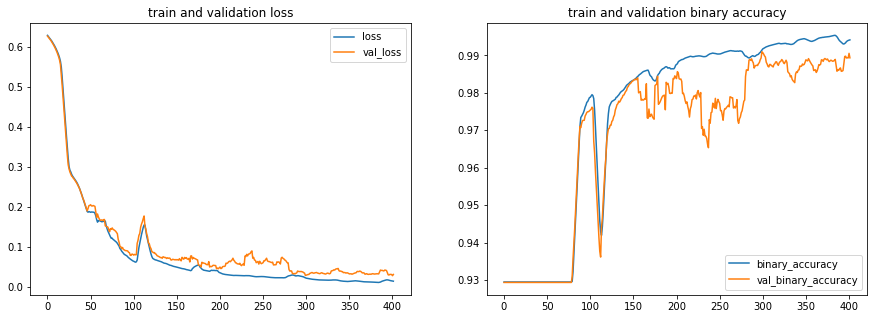

In [16]:
# plot loss and accuracy
plot_history(history)

In [17]:
test = predictions[0][0]

Accuracy: 0.993


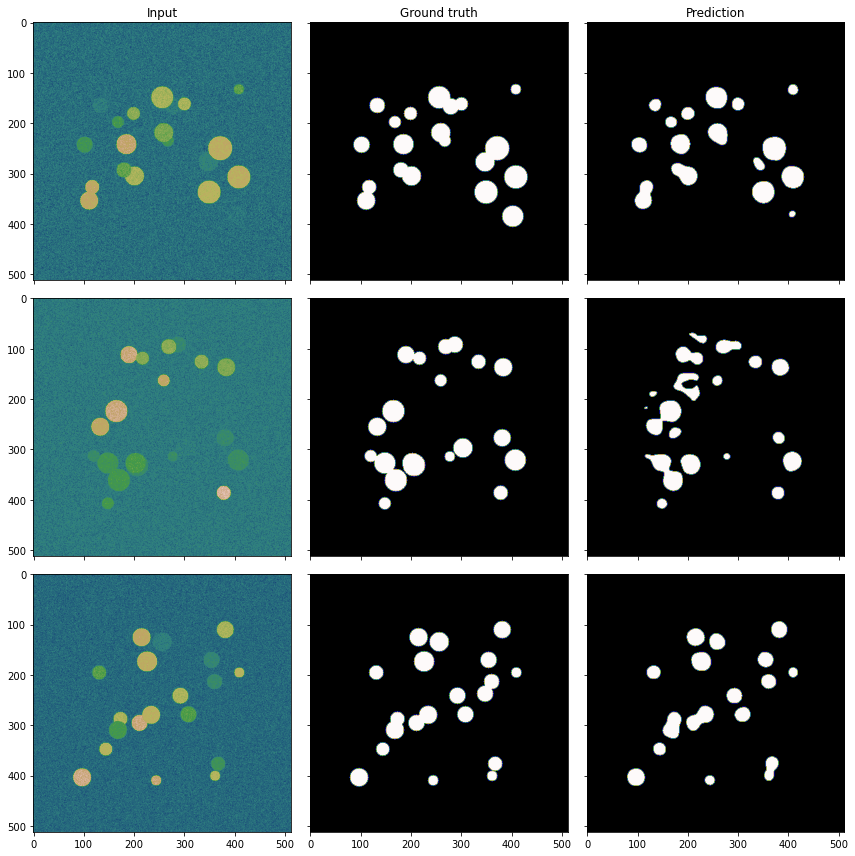

In [18]:
# evaluate and plot predicted results
predictions, accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(accuracy))
show_predictions(x_test, y_test, predictions)

#### The training of the networks depend on many hyperparameters such as
- network architecture: #layers, #fmaps
- batch size, learning rate
- number and distribution of the training samples

#### You can play and see how these settings influence the learning curve.
![image.png](utils/example_learning_curves/lc_all.png)

![](example_learning_curves/lc_all.png)

### A2: Use early stopping to avoid overfitting

In [19]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    Code from https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
    """
    def __init__(self, patience=20, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [20]:
# define model
out_channels = 1
d_factors = [[2,2],[2,2],[2,2],[2,2]]
activation = torch.nn.Sigmoid()
early_stopping = EarlyStopping(patience=60)

net = torch.nn.Sequential(
    UNet(in_channels=1,
    num_fmaps=6,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='same',
    num_fmaps_out=6,
    constant_upsample=False
    ),
    torch.nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

In [21]:
# train model
epochs = 500
net, history_w_ea,_ = train(net, epochs, learning_rate=5e-4, early_stopping=early_stopping)
print('Finished Training')

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 1, train-loss: 0.5456 - train_accuracy:0.9295 - val_loss:0.5452 -val_accuracy:0.9294
Epoch 2, train-loss: 0.5448 - train_accuracy:0.9295 - val_loss:0.5441 -val_accuracy:0.9294
Epoch 3, train-loss: 0.5436 - train_accuracy:0.9295 - val_loss:0.5428 -val_accuracy:0.9294
Epoch 4, train-loss: 0.5423 - train_accuracy:0.9295 - val_loss:0.5413 -val_accuracy:0.9294
Epoch 5, train-loss: 0.5408 - train_accuracy:0.9295 - val_loss:0.5397 -val_accuracy:0.9294
Epoch 6, train-loss: 0.5390 - train_accuracy:0.9295 - val_loss:0.5376 -val_accuracy:0.9294
Epoch 7, train-loss: 0.5367 - train_accuracy:0.9295 - val_loss:0.5348 -val_accuracy:0.9294
Epoch 8, train-loss: 0.5338 - train_accuracy:0.9295 - val_loss:0.5318 -val_accuracy:0.9294
Epoch 9, train-loss: 0.5308 - train_accuracy:0.9295 - val_loss:0.5286 -val_accuracy:0.9294
Epoch 10, train-loss: 0.5275 - train_accuracy:0.9295 - val_loss:0.5250 -val_accuracy:0.9294
Epoch 11, train-loss: 0.5238 - train_accuracy:0.9295 - val_loss:0.5210 -val_accuracy:0.92

Epoch 93, train-loss: 0.0307 - train_accuracy:0.9911 - val_loss:0.1058 -val_accuracy:0.9894
Epoch 94, train-loss: 0.0301 - train_accuracy:0.9913 - val_loss:0.1184 -val_accuracy:0.9863
Epoch 95, train-loss: 0.0296 - train_accuracy:0.9913 - val_loss:0.1272 -val_accuracy:0.9832
Epoch 96, train-loss: 0.0287 - train_accuracy:0.9918 - val_loss:0.1114 -val_accuracy:0.9883
Epoch 97, train-loss: 0.0284 - train_accuracy:0.9921 - val_loss:0.1263 -val_accuracy:0.9793
Epoch 98, train-loss: 0.0280 - train_accuracy:0.9918 - val_loss:0.1379 -val_accuracy:0.9701
Epoch 99, train-loss: 0.0278 - train_accuracy:0.9922 - val_loss:0.1214 -val_accuracy:0.9783
Epoch 100, train-loss: 0.0270 - train_accuracy:0.9922 - val_loss:0.1471 -val_accuracy:0.9564
Epoch 101, train-loss: 0.0266 - train_accuracy:0.9922 - val_loss:0.1337 -val_accuracy:0.9638
Epoch 102, train-loss: 0.0257 - train_accuracy:0.9929 - val_loss:0.1440 -val_accuracy:0.9518
Epoch 103, train-loss: 0.0255 - train_accuracy:0.9927 - val_loss:0.2153 -val_

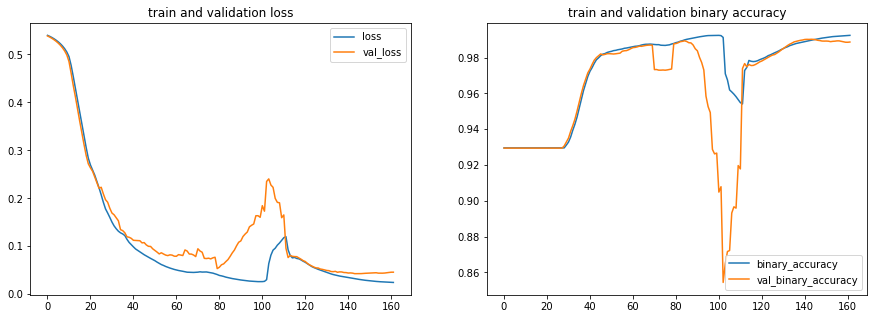

In [22]:
# plot loss and accuracy
plot_history(history_w_ea)

Accuracy: 0.992


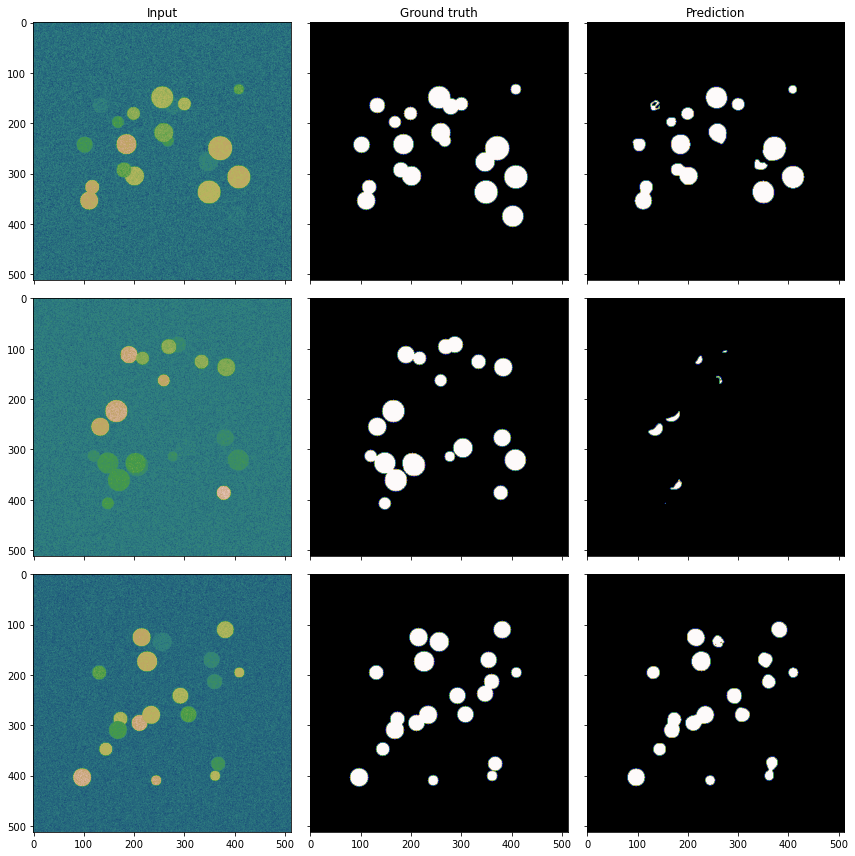

In [23]:
# evaluate and plot predicted results
predictions, accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(accuracy))
show_predictions(x_test, y_test, predictions)

### A3: Use a data generator to avoid overfitting

In [43]:
# As we have simulated data, we can use unlimited number of training examples
# image generator copied from https://github.com/jakeret/tf_unet
import utils.image_gen as image_gen

In [44]:
# define image shape
nx = 512
ny = 512

# create a wrapper generator 
def train_generator(batch_size):
    
    # init image generator with the following parameters:
    # nx, ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, limit_num_samples = -1, binary = True
    #generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=20, r_min=10, r_max=25, binary=True)
    data_generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=20, r_min=10, r_max=25, binary=True)
   # batch_labels = np.zeros((batch_size, 1)) 
    while True:
        data, labels = data_generator(batch_size)
        data=torch.tensor(data).type(torch.FloatTensor)
        labels=torch.tensor(labels)
        yield data, labels

In [45]:
# define model
out_channels = 1
d_factors = [[2,2],[2,2],[2,2],[2,2]]
activation = torch.nn.Sigmoid()
early_stopping = EarlyStopping(patience=60)

net = torch.nn.Sequential(
    UNet(in_channels=1,
    num_fmaps=6,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='same',
    num_fmaps_out=6,
    constant_upsample=False
    ),
    torch.nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

In [46]:
# train model
epochs = 300
net, history_w_gen,_ = train(net, epochs, learning_rate=8e-3, early_stopping=early_stopping,img_gen=iter(train_generator(4)))
print('Finished Training')

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1, train-loss: 0.7097 - train_accuracy:0.0705 - val_loss:0.6798 -val_accuracy:0.9255
Epoch 2, train-loss: 0.6798 - train_accuracy:0.9303 - val_loss:0.6347 -val_accuracy:0.9294
Epoch 3, train-loss: 0.6351 - train_accuracy:0.9277 - val_loss:0.5441 -val_accuracy:0.9294
Epoch 4, train-loss: 0.5465 - train_accuracy:0.9269 - val_loss:0.5784 -val_accuracy:0.9294
Epoch 5, train-loss: 0.5467 - train_accuracy:0.9336 - val_loss:0.4435 -val_accuracy:0.9294
Epoch 6, train-loss: 0.4472 - train_accuracy:0.9250 - val_loss:0.4630 -val_accuracy:0.9294
Epoch 7, train-loss: 0.4675 - train_accuracy:0.9266 - val_loss:0.4492 -val_accuracy:0.9294
Epoch 8, train-loss: 0.4508 - train_accuracy:0.9295 - val_loss:0.4160 -val_accuracy:0.9294
Epoch 9, train-loss: 0.4134 - train_accuracy:0.9335 - val_loss:0.3537 -val_accuracy:0.9294
Epoch 10, train-loss: 0.3579 - train_accuracy:0.9279 - val_loss:0.2767 -val_accuracy:0.9294
Epoch 11, train-loss: 0.2454 - train_accuracy:0.9394 - val_loss:0.2649 -val_accuracy:0.92

Epoch 91, train-loss: 0.0780 - train_accuracy:0.9320 - val_loss:0.0771 -val_accuracy:0.9294
Epoch 92, train-loss: 0.0692 - train_accuracy:0.9377 - val_loss:0.0790 -val_accuracy:0.9294
Epoch 93, train-loss: 0.0994 - train_accuracy:0.9328 - val_loss:0.0774 -val_accuracy:0.9294
Epoch 94, train-loss: 0.0796 - train_accuracy:0.9373 - val_loss:0.0769 -val_accuracy:0.9294
Epoch 95, train-loss: 0.0687 - train_accuracy:0.9346 - val_loss:0.0766 -val_accuracy:0.9294
Epoch 96, train-loss: 0.0852 - train_accuracy:0.9336 - val_loss:0.0778 -val_accuracy:0.9294
Epoch 97, train-loss: 0.0904 - train_accuracy:0.9286 - val_loss:0.0858 -val_accuracy:0.9294
Epoch 98, train-loss: 0.0821 - train_accuracy:0.9346 - val_loss:0.1086 -val_accuracy:0.9294
Epoch 99, train-loss: 0.0773 - train_accuracy:0.9335 - val_loss:0.1263 -val_accuracy:0.9294
Epoch 100, train-loss: 0.0944 - train_accuracy:0.9294 - val_loss:0.1573 -val_accuracy:0.9294
Epoch 101, train-loss: 0.1047 - train_accuracy:0.9290 - val_loss:0.1258 -val_ac

Epoch 180, train-loss: 0.0725 - train_accuracy:0.9892 - val_loss:0.0816 -val_accuracy:0.9919
Epoch 181, train-loss: 0.0770 - train_accuracy:0.9862 - val_loss:0.0819 -val_accuracy:0.9919
Epoch 182, train-loss: 0.0843 - train_accuracy:0.9877 - val_loss:0.0820 -val_accuracy:0.9919
Epoch 183, train-loss: 0.0818 - train_accuracy:0.9882 - val_loss:0.0862 -val_accuracy:0.9920
Epoch 184, train-loss: 0.0739 - train_accuracy:0.9889 - val_loss:0.0923 -val_accuracy:0.9918
Epoch 185, train-loss: 0.0884 - train_accuracy:0.9930 - val_loss:0.0710 -val_accuracy:0.9916
Epoch 186, train-loss: 0.1610 - train_accuracy:0.9771 - val_loss:0.0806 -val_accuracy:0.9863
Epoch 187, train-loss: 0.0649 - train_accuracy:0.9888 - val_loss:0.1181 -val_accuracy:0.9772
Epoch 188, train-loss: 0.1334 - train_accuracy:0.9772 - val_loss:0.1559 -val_accuracy:0.9739
Epoch 189, train-loss: 0.1710 - train_accuracy:0.9720 - val_loss:0.1746 -val_accuracy:0.9714
Epoch 190, train-loss: 0.2245 - train_accuracy:0.9693 - val_loss:0.169

Epoch 270, train-loss: 0.0681 - train_accuracy:0.9882 - val_loss:0.0733 -val_accuracy:0.9917
Epoch 271, train-loss: 0.0815 - train_accuracy:0.9864 - val_loss:0.0729 -val_accuracy:0.9917
Epoch 272, train-loss: 0.0759 - train_accuracy:0.9850 - val_loss:0.0748 -val_accuracy:0.9919
Epoch 273, train-loss: 0.0574 - train_accuracy:0.9918 - val_loss:0.0760 -val_accuracy:0.9920
Epoch 274, train-loss: 0.0607 - train_accuracy:0.9924 - val_loss:0.0751 -val_accuracy:0.9920
Epoch 275, train-loss: 0.0637 - train_accuracy:0.9915 - val_loss:0.0709 -val_accuracy:0.9919
Epoch 276, train-loss: 0.0635 - train_accuracy:0.9916 - val_loss:0.0684 -val_accuracy:0.9919
Epoch 277, train-loss: 0.0793 - train_accuracy:0.9872 - val_loss:0.0647 -val_accuracy:0.9916
Epoch 278, train-loss: 0.0531 - train_accuracy:0.9934 - val_loss:0.0631 -val_accuracy:0.9912
Epoch 279, train-loss: 0.0685 - train_accuracy:0.9889 - val_loss:0.0628 -val_accuracy:0.9910
Epoch 280, train-loss: 0.0698 - train_accuracy:0.9869 - val_loss:0.062

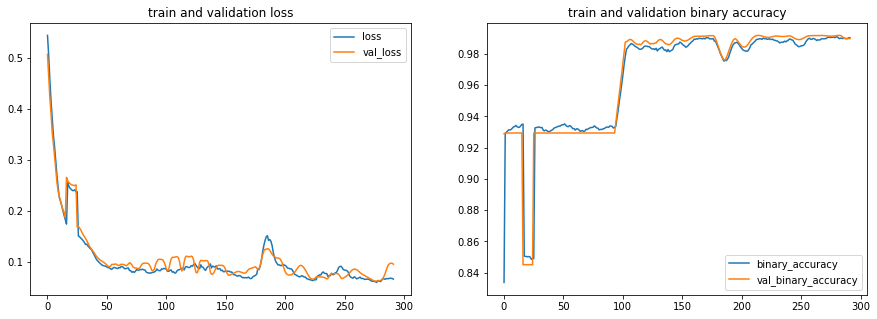

In [47]:
# plot loss and accuracy
plot_history(history_w_gen)

Accuracy: 0.991
Heads up: If prediction is below 0.9 then the prediction map is shown.
Max predictions: [0.62404215 0.62404215 0.62404215]


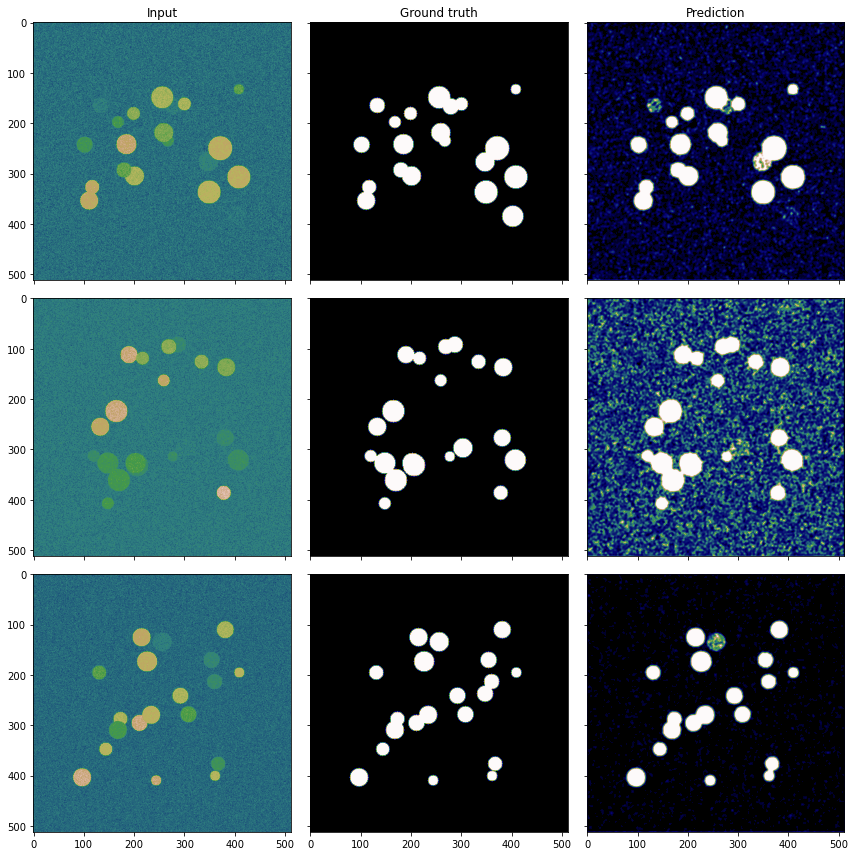

In [48]:
# evaluate and plot predicted results
predictions, accuracy = predict(net, test_loader)
predictions = np.stack(predictions, axis=0)
print('Accuracy: {:.3f}'.format(accuracy))
show_predictions(x_test, y_test, predictions)